In [1]:
# Deep Reinforcement Learning for Automated Stock Trading – for Crypto

### 📊 Summary of Crypto DRL Ensemble Trading

# This notebook implements a deep reinforcement learning ensemble strategy adapted from the ICAIF 2020 paper, applied to cryptocurrency trading.

#- **Assets Used**: BTC, ETH, BNB, XRP
#- **Time Period**: 2018 to 2024, with rolling windows
#- **Agents Used**: PPO, A2C, DDPG (Stable-Baselines3)
#- **Strategy**:
#  - Train each agent on a rolling window (e.g. 6 months)
#   - Validate on 2 months of unseen data
#   - Select the model with the highest Sharpe ratio
#   - Trade using the best model for 2 months
# - **Objective**: Observe the effectiveness of the agents using the ensemble strategy.


In [2]:
import os
import pandas as pd
import sys

sys.path.append("..")

from finrl.utils.rolling_windows import get_rolling_windows
from finrl.pipeline.windows import run_training_windows
from finrl.meta.preprocessor.preprocessors import FeatureEngineer
from finrl.meta.preprocessor.binancedownloader import BinanceDownloader
from finrl.meta.preprocessor.binancedownloader import BinanceDownloader

In [3]:
# from finrl.config import TRAIN_START_DATE, TRAIN_END_DATE, TEST_START_DATE, TEST_END_DATE, TRADE_START_DATE, TRADE_END_DATE
import os
from pathlib import Path

TRAIN_START_DATE = "2020-05-04"  
TRAIN_END_DATE = "2023-04-29"   

TEST_START_DATE = "2023-04-30" 
TEST_END_DATE = "2024-05-31"

TRADE_START_DATE = "2024-06-01"
TRADE_END_DATE = "2025-05-31"

data_path = "../data/binance_less_raw.csv"

# current_dir = os.path.dirname(__file__)
notebook_path = Path().resolve()
current_dir = notebook_path.parent
data_path = os.path.join(current_dir, "data")
results_path = os.path.join(current_dir, "results")
file_name = "binance_data_raw.csv"
dt_raw_path = os.path.join(data_path, file_name)
dt_processed_path = os.path.join(data_path, "processed_bnc_data.csv")

# tickers = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "SOLUSDT", "XRPUSDT"]

tickers = ["BTCUSDT", "ETHUSDT"]
bd = BinanceDownloader()

df_raw = bd.download_multiple(ticker_list=tickers, start_str="1 Jan, 2018")
df_raw.to_csv(dt_raw_path, index=False)
print("Data saved to:", data_path)

print("Done...")


Data saved to: /home/derya/finrl_research/data
Done...


In [4]:
df_raw.groupby("tic")["date"].min()

tic
BTC-USD   2018-01-01
ETH-USD   2018-01-01
Name: date, dtype: datetime64[ns]

In [5]:

fe = FeatureEngineer(use_technical_indicator=False,
                    tech_indicator_list=["macd", "rsi_30", "cci_30"], 
                    use_vix=False,
                    use_turbulence=True)

df_processed = fe.preprocess_data(df_raw) 
if os.path.exists(data_path):
    df_processed.to_csv(dt_processed_path, index=False)


TODO: must add technical indicators
TODO: add volatility indicators


In [6]:
from finrl.config import TRAIN_LEN, VAL_LEN, TRADE_LEN, TRAIN_START_DATE, TRADE_END_DATE

start_date = pd.Timestamp(TRAIN_START_DATE)
end_date = pd.Timestamp(TRADE_END_DATE)

windows = get_rolling_windows(
    train_months=TRAIN_LEN,
    val_months=VAL_LEN,
    trade_months=TRADE_LEN,
    start_date_str=start_date,
    end_date_str=end_date
)

print(f"Generated {len(windows)} rolling windows from {TRAIN_START_DATE} to {TRADE_END_DATE}.")



Created 26 rolling windows.
Generated 26 rolling windows from 2020-05-04 to 2025-05-31.


In [7]:
from stable_baselines3.common.vec_env import DummyVecEnv
from finrl.pipeline.plot_values import plot_dashboard #plot_account_values, plot_counts_rewards, plot_volatility_return, plot_sharp_window
from finrl.meta.preprocessor.preprocessors import data_split
from finrl.meta.env_crypto_trading.env_cryptotrading import CryptoTradingEnv
from finrl.agents.stablebaselines3.models import DRLAgent
from finrl.plot.plot import get_daily_return  
from finrl.config import model_configs

import numpy as np

## from finrl.plot import get_daily_return

account_values = df_result["account_value"]
daily_returns = get_daily_return(account_values)

sharpe = (252**0.5) * daily_returns.mean() / daily_returns.std()
total_return = account_values.iloc[-1] / account_values.iloc[0] - 1
volatility = daily_returns.std()
max_drawdown = (account_values.cummax() - account_values).max() / account_values.cummax().max()


df_final = pd.concat(results)
backtest_stats(df_final)
backtest_plot(df_final)

In [8]:
from finrl.config import model_configs, LOOKBACK_DAYS

val_results_path = os.path.join(results_path, "validation_metrix.csv")
trade_results_path = os.path.join(results_path, "trading_metrix.csv")
daily_accounts_path = os.path.join(results_path, "account_values.csv")

performance_log = []
# val_report_metrics = []

PPO_model_kwargs = model_configs["PPO"]
A2C_model_kwargs = model_configs["A2C"]
DDPG_model_kwargs = model_configs["DDPG"]

In [9]:

for i, (train_start, train_end, val_start, val_end, trade_start, trade_end) in enumerate(windows):
        train_data = data_split(df_processed, train_start, train_end)
        val_data = data_split(df_processed, val_start, val_end)
        trade_data = data_split(df_processed, trade_start, trade_end)
        min_days_required = 30
        
        window_name = f"window_{i+1}"
        print(f" Rolling {window_name}: {train_start.date()} to {trade_end.date()}")

        env_train = DummyVecEnv([lambda: CryptoTradingEnv(train_data)])
        agent = DRLAgent(env=env_train)

        models = {
            "ppo": agent.train_PPO(total_timesteps=len(train_data)*30, model_kwargs=PPO_model_kwargs),
            "a2c": agent.train_A2C(total_timesteps=len(train_data)*30, model_kwargs=A2C_model_kwargs),
            "ddpg": agent.train_DDPG(total_timesteps=int(len(train_data)*30*0.5), model_kwargs=DDPG_model_kwargs)
        }

        best_model = None
        best_sharpe = -np.inf
        val_sharpes = []
        val_report = []

        for name, model in models.items():
            env_val = DummyVecEnv([lambda: CryptoTradingEnv(val_data)])
            sharpe_metrics = DRLAgent.DRL_evaluation(model=model, environment=env_val, lookback_days=LOOKBACK_DAYS)
            sharpe = sharpe_metrics["sharpe"]
            val_sharpes.append({"name": name, "sharpe": sharpe})
            # account_vals = env_val.envs[0].asset_memory

            if not np.isnan(sharpe) and sharpe > best_sharpe:
                best_model = model
                best_sharpe = sharpe     

        #  --- Trade start ---
        env_trade = DummyVecEnv([lambda: CryptoTradingEnv(trade_data)])
        
        # Sharpe/volatility during validation can be compared against to the actual during training
        # val_sharpe_dict = {name: sharpe for name, sharpe in val_sharpes}

        if best_model is not None:
                startdt = pd.to_datetime(trade_start)
                env_trade.envs[0].trading_mode = True
                df_result = DRLAgent.DRL_prediction(model=best_model, environment=env_trade, start_date=startdt, lookback_days=LOOKBACK_DAYS)

                df_result["window"] = i + 1
                
                # concat for reporting
                if "account_values_df" not in locals():
                    account_values_df = df_result.copy()
                else:
                    account_values_df = pd.concat([account_values_df, df_result], ignore_index=True)

                daily_retun_values_df = df_result[["date", "account_value"]].copy()
                # daily_retun_values_df["date"] = pd.to_datetime(daily_retun_values_df["date"])
                # daily_retun_values_df.set_index("date", inplace=True)
                account_values = daily_retun_values_df["account_value"]

                daily_returns = get_daily_return(daily_retun_values_df)       
                sharpe = (365**0.5) * daily_returns.mean() / daily_returns.std()      
                # sharpe = df_result["sharpe"]
                total_return = account_values.iloc[-1] / account_values.iloc[0] - 1
                volatility = daily_returns.std()
                max_drawdown = (account_values.cummax() - account_values).max() / account_values.cummax().max()

                # print(f"account_values {account_values}")
                # print(f"account_values.iloc[0] {account_values.iloc[0]}")

                # expected_days = len(env.df.date.unique())
                # print(len(account_values), expected_days)
                


                performance_log.append({
                        "agent": best_model.__class__.__name__,
                        "window": i + 1,
                        "train_start": train_start.date(),
                        "train_end": train_end.date(),
                        "trade_start": trade_start.date(),
                        "trade_end": trade_end.date(),
                        "sharpe_ratio": sharpe,
                        "min_account_value": account_values.min(),
                        "max_account_value": account_values.max(),
                        "total_return": total_return,
                        "volatility (std)": volatility,
                        "max_drawdown": max_drawdown,
                        "initial_acc_val": account_values.iloc[0],
                        "final_acc_val": account_values.iloc[-1]
                    })
        else:
            print(f"❌ No valid model selected in window {i+1} — skipping trade step.")


            #  --- Trade End ---

            print(f"✅ Window {i+1} Summary:")
            print(f"  🔹 Train Dates : {train_start.date()} → {train_end.date()}")
            print(f"  🔹 Trade Dates : {traid_start.date()} → {trade_end.date()}")
            print(f"  🔹 Best Model  : {best_model.__class__.__name__ if best_model else 'None'}")
            print(f"  🔹 Sharpe      : {best_sharpe:.2f}")
            #  --- validation data reporting ---
        # val_report = {
        #     "agent": best_model.__class__.__name__,
        #     "window": i + 1,
        #     "train_start": train_start.date(),
        #     "train_end": train_end.date(),
        #     "val_start": val_start,
        #     "val_end": val_end,
        # }
        # for sharpe_entry in val_sharpes:
        #     model_name = sharpe_entry["name"]
        #     val_report[f"{model_name}_sharpe"] = sharpe_entry["sharpe"]

        # val_report_metrics.append(val_report)

 Rolling window_1: 2020-05-04 to 2021-03-03
Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1529 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1255          |
|    iterations           | 2             |
|    time_elapsed         | 3             |
|    total_timesteps      | 4096          |
| train/                  |               |
|    approx_kl            | 0.0062131835  |
|    clip_fraction        | 0.0368        |
|    clip_range           | 0.2           |
|    entropy_loss         | -2.84         |
|    explained_variance   | -0.0016453266 |
|    learning_rate        | 0.00025       |
|    loss                 | 46.4          |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.00301      |
|    std                 

  if val_report_metrics:
        val_metrics = pd.DataFrame(val_report_metrics)
        val_metrics.to_csv(val_results_path, index=False)
        print(f"Metrics saved to", {val_results_path})
        # display(val_report_metrics) - look for import matplotlib.pyplot as plt

    else:
        print("No validation report to analyze.")

In [10]:
# if not performance_log:
df_metrics = pd.DataFrame(performance_log)
df_metrics.to_csv(trade_results_path, index=False)
print(f"Trade Metrics saved to", {trade_results_path})
# else:
#     print("No results to analyze.")

# if not account_values_df.empty():
account_values_df.to_csv(daily_accounts_path, index=False)
print(f"Daily account values saved to", {daily_accounts_path})

Trade Metrics saved to {'/home/derya/finrl_research/results/trading_metrix.csv'}
Daily account values saved to {'/home/derya/finrl_research/results/account_values.csv'}


/home/derya/finrl_research/notebooks/../finrl/pipeline/plot_values.py:17: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=account_values_df, x="window", y="trade_count", ax=axes[1, 0], ci=None)
/home/derya/finrl_research/notebooks/../finrl/pipeline/plot_values.py:21: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=metrics_df, x="window", y="volatility (std)", ax=axes[1, 1], ci=None)


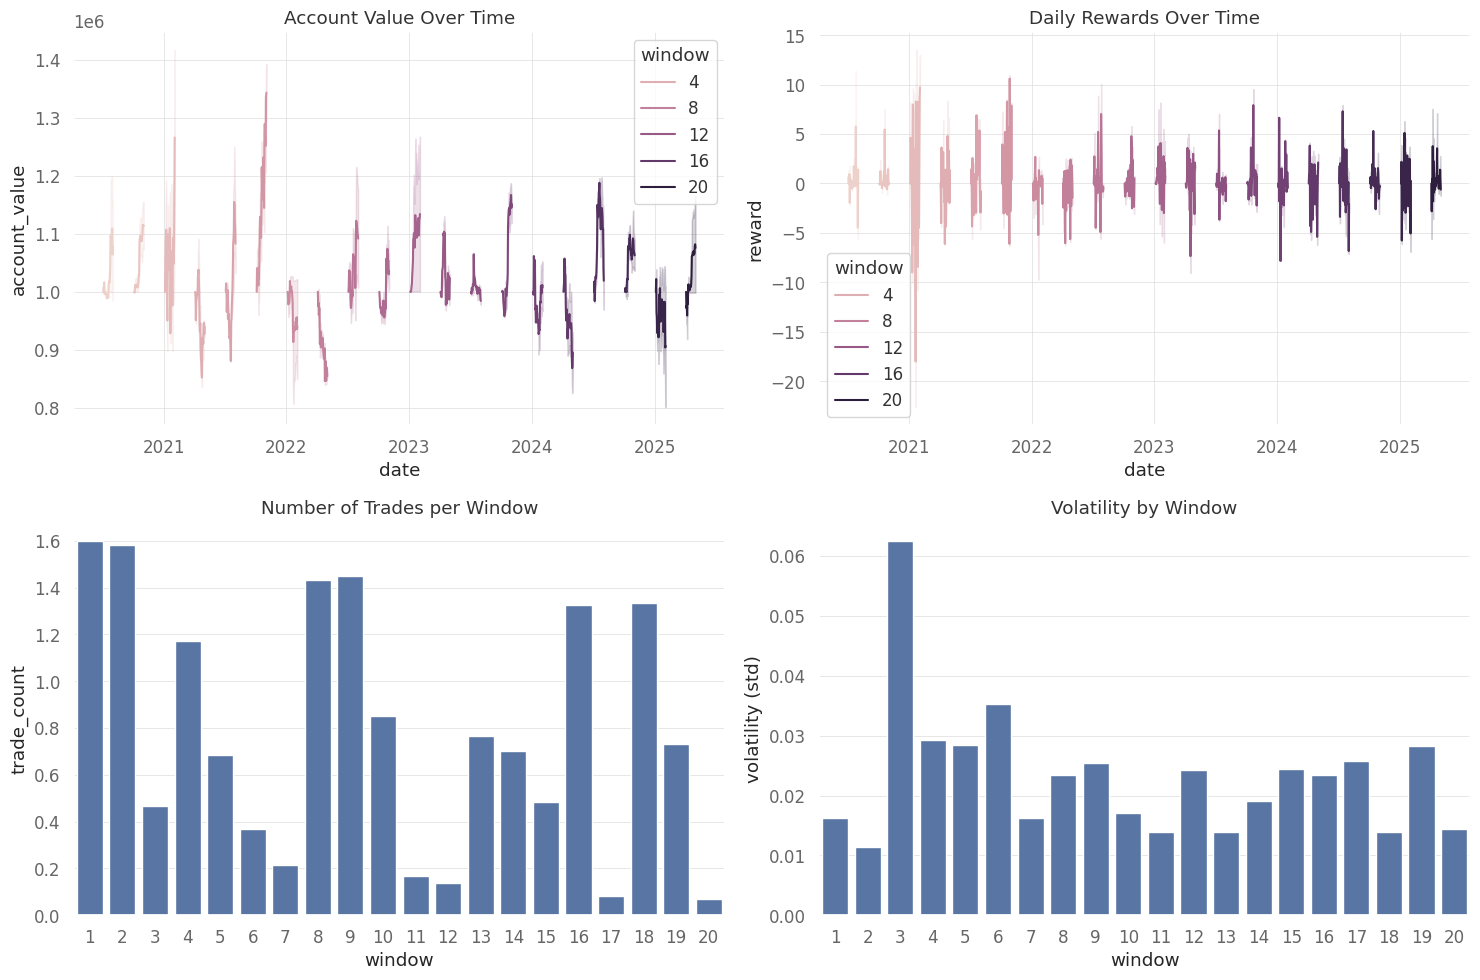

In [14]:
# import matplotlib.pyplot as plt
# import seaborn as sns

